# Regression Progressive Learner
## Moving Gaussian Experiment
When considering adversarial settings in a progressive learner, it is important to quantify the effects of an adversarial transformer on a progressive learner. In this two-task experiment, we use two Gaussian distributions with varying means to illustrate this effect. We fix task 1 around the mean [4,4] and slide task 2's mean along the line y=x. As the means of task 2 approach those of task 1, we should see the BTE and FTE rise and reach their max transfer efficiencies when the two means are the same and drop off as the two means separate.

In [1]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split
from math import log2, ceil

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleAverage, LinearRegressionDecider
from proglearn.transformers import TreeRegressionTransformer
from proglearn.voters import TreeRegressionVoter
from joblib import Parallel, delayed

C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\ten

In [2]:
# Function for generating Gaussian samples with a specific correlation and mean.
def generateGaussians(sample_size, corr, means):
    # Assign the means and covariance.
    mean = means
    cov = [[1, corr], [corr, 1]]
    # Create the multvariate normals.
    x = np.random.multivariate_normal(mean, cov, sample_size)
    # Create the outputs with the inputs.
    z = makeOutput(x)
    return x,z

In [3]:
# Function for generating Gaussian samples with a specific correlation and mean.
def makeOutput(x):
    # Return the L1 norm of the input array.
    return np.sum(np.abs(x), axis=1)

In [4]:
# Plot the distributions of the input vectors.
def plot_distributions(x1, x2, title):
    colors = sns.color_palette("Dark2", n_colors=2)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].scatter(x1[:,0], x1[:,1], s=50)
    ax[1].scatter(x2[:,0], x2[:,1], s=50)

    ax[0].set_xlim([-8, 8])
    ax[0].set_ylim([-8, 8])
    ax[1].set_xlim([-8, 8])
    ax[1].set_ylim([-8, 8])
    
    ax[0].set_title('Task 1')
    ax[1].set_title('Task 2')

    plt.tight_layout()
    plt.show()

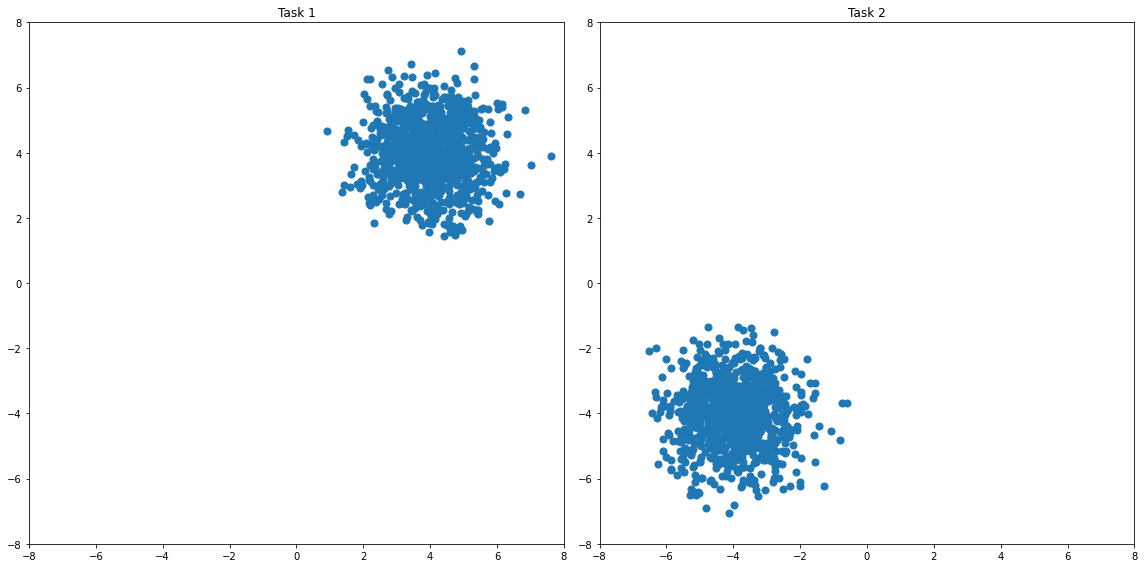

Text(0.5, 0.92, 'Task 2: L1 distance')

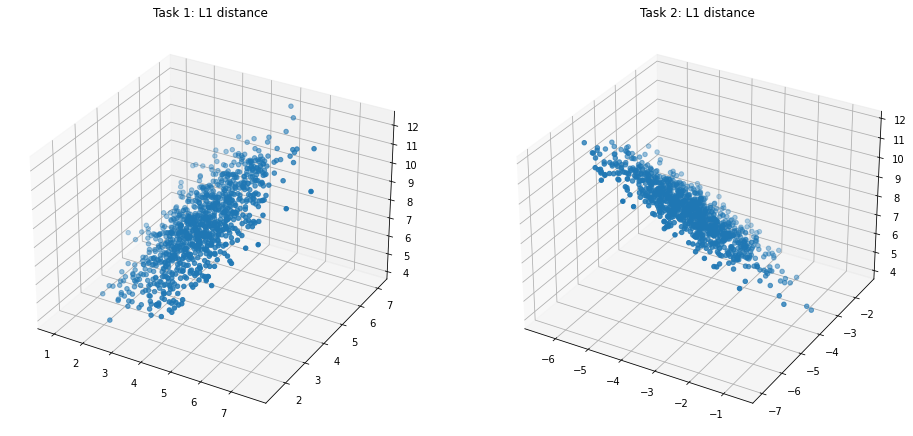

In [5]:
# Creates the means_1, means_2
means_1 = (4,4)
means_2 = (-4,-4)

# Generate Gaussians with the specific samplesize and correlation.
X1, Z1 = generateGaussians((1000), 0, means_1)
X2, Z2 = generateGaussians((1000), 0, means_2)

# Plot the distributions of the 2D data.
plot_distributions(X1, X2, ['Task 1', 'Task 2'])

# Plot the 3D distributions with the z distances.
fig = plt.figure(figsize=(16, 8))
# Add the first task data
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.scatter3D(X1[:,0],X1[:,1], Z1)
ax1.set_title('Task 1: L1 distance')
# Add the second task data
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.scatter3D(X2[:,0],X2[:,1], Z2)
ax2.set_title('Task 2: L1 distance')

"Backward transfer efficiency is the expected ratio of (i) the risk of the learned hypothesis with access to the data up to and including the last observation from task t, to (ii) the risk of the learned hypothesis with access to the entire data sequence. Thus, this quantity measures the relative effect of future task data on the performance on task t." [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf)

To derive Backwards Transfer Efficiency in this example:
1. We first train a single learner on Task 1 data and record the mean-squared error (MSE) between the predicted and actual values on a testing set of task 1 data.This will act as the risk of the learned hypothesis with access to n=750 samples for task 1.
2. We then train another learner on task 1 data and introduce an additional transformer trained on n=750 samples of task 2 data and record the MSE between the predicted and actual values on a testing set of task 1 data. This will act as the risk of the learned hypothesis with access to the entire data.
3. We then take the ratio between the two values to get the BTE.

If the generalization error is lower with the additional transformer, then we can see that the BTE will be larger than 1, so backwards transfer has occurred. If the generalization error is higher with the additional transformer, then we can see that backwards transfer has not occurred.

In [6]:
def experiment_BTE(samples_task_1, samples_task_2, n_test, n_trees, max_depth, corr, means_1, means_2, acorn=None):
    
    # See if the sample sizes for both training sets are given.
    if samples_task_1 == 0 and samples_task_2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it.
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, task 1, and task 2.
    errors = np.zeros(2, dtype=float)

    # Initialize the transformer type and arguments.
    default_transformer_class = TreeRegressionTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    # Initialize the voter type and arguments.
    default_voter_class = TreeRegressionVoter
    default_voter_kwargs = {}

    # Initialize the decider type and arguments.
    default_decider_class = SimpleAverage
    default_decider_kwargs = {}

    # Initialize the progressive learner using the transformer, voter and decider classes.
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = default_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class,
                                             default_decider_kwargs = default_decider_kwargs)
    
    # Create the datasets with the Gaussian mean for task 1 and task 2.
    if (samples_task_1 != 0):
        X1,Z1 = generateGaussians(samples_task_1, corr, means_1)
        X1_test,Z1_test = generateGaussians(n_test, corr, means_1)
    if (samples_task_2 != 0):
        X2,Z2 = generateGaussians(samples_task_2, -corr, means_2)
        X2_test,Z2_test = generateGaussians(n_test, -corr, means_2)
    
    # If there is no sample size for task 1, train a progressive learner on task 2 data.
    if (samples_task_1 == 0 and samples_task_2 != 0):
        progressive_learner.add_task(X2, Z2)
        predicted_Z2 = progressive_learner.predict_proba(X2_test, task_id=0)
        # Set the errors for task 1 for to be 1.0, set the errors for task 2 to be the MSE
        # between the predicted set and the actual set.
        errors[0] = 1.0
        errors[1] = mean_squared_error(predicted_Z2, Z2_test)

    # If there is no sample size for task 2, train a progressive learner on task 1 data.
    elif (samples_task_2 == 0 and samples_task_1 != 0):
        progressive_learner.add_task(X1, Z1)
        predicted_Z1 = progressive_learner.predict_proba(X1_test, task_id=0)
        # Set the errors for task 2 for to be 1.0, set the errors for task 1 to be the MSE
        # between the predicted set and the actual set.
        errors[0] = mean_squared_error(predicted_Z1, Z1_test)
        errors[1] = 1.0

    # If both sample sizes are given, proceed as follows.
    elif (samples_task_2 != 0 and samples_task_1 != 0):
        # Add a task for the task 1, predict the probabilities and add the MSE to the error array.
        progressive_learner.add_task(X1, Z1)
        predicted_Z1 = progressive_learner.predict_proba(X1_test, task_id=0)
        errors[0] = mean_squared_error(predicted_Z1, Z1_test)
        # Then, add the transformer trained on task 2, predict and add the MSE to the error array.
        progressive_learner.add_transformer(X2, Z2,
                                            transformer_class=default_transformer_class,
                                            transformer_kwargs=default_transformer_kwargs,
                                            voter_class=default_voter_class,
                                            voter_kwargs=default_voter_kwargs,
                                            transformer_id=1
                                           )
        predicted_transformer_Z1 = progressive_learner.predict_proba(X1_test, task_id=0)
        errors[1] = mean_squared_error(predicted_transformer_Z1, Z1_test)
        
    return errors

In [15]:
# Set up the tree parameters.
mc_rep = 1000
n_test = 1000
n_trees = 10
n_sample_size = 1000
max_depth = 10

# Set up the data parameters.
corr = 0
means_1 = [(4,4)]
means_2 = [(-4,-4),(-3,-3),(-2,-2),(-1,-1),(0,0),(1,1),(2,2),(3,3),(4,4),
          (5,5),(6,6),(7,7),(8,8),(9,9),(10,10),(11,11),(12,12)]

# Set up sample sizes.
samples_task_1 = 750
samples_task_2 = 750

In [16]:
# Initiate error arrays
mean_error_bte = np.zeros((2, len(means_1) + len(means_2)))
std_error_bte = np.zeros((2, len(means_1) + len(means_2)))

# Initiate transfer efficiency arrays
mean_bte = np.zeros((1, len(means_1) + len(means_2)))

# Create the error.
error = np.array(
    Parallel(n_jobs=-1, verbose=1)(
        delayed(experiment_BTE)(
            samples_task_1, 0, n_test, n_trees, max_depth, corr, means_1[0], None) for _ in range(mc_rep)
        )
    )
mean_error_bte[:,0] = np.mean(error,axis=0)
std_error_bte[:,0] = np.std(error,ddof=1,axis=0)
mean_bte[0,0] = 0

# Iterate over the means of task 2.
for i, n1 in enumerate(means_2):
    print('starting to compute - mean_1: {}, mean_2={}\n'.format(means_1, n1))
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment_BTE)(
                samples_task_1, samples_task_2, n_test, n_trees,max_depth, corr, means_1[0], n1) for _ in range(mc_rep)
            )
        )
    mean_error_bte[:,i+1] = np.mean(error,axis=0)
    std_error_bte[:,i+1] = np.std(error,ddof=1,axis=0)
    mean_bte[0,i+1] = mean_error_bte[0,i+1] / mean_error_bte[1,i+1]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(-4, -4)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(-3, -3)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(-2, -2)



[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(-1, -1)



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(0, 0)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(1, 1)



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(2, 2)



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(3, 3)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(4, 4)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(5, 5)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(6, 6)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(7, 7)



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(8, 8)



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(9, 9)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(10, 10)



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(11, 11)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: [(4, 4)], mean_2=(12, 12)



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.6s finished


"Forward transfer efficiency is the expected ratio of (i) the risk of the learned hypothesis with access only to task t data, to (ii) that with sequential access to the data up to and including the last observation from task t. This quantity measures the relative effect of previously seen out-of-task data on the performance on task t." [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf)

To derive Forwards Transfer Efficiency in this example:
1. We first train a single learner on Task 2 data and record the mean-squared error (MSE) between the predicted and actual values on a testing set of task 1 data. This will act as the risk of the learned hypothesis with access to n=750 samples for task 2.
2. We introduce an additional transformer trained on n=750 samples of task 1 data and record the MSE between the predicted and actual values on a testing set of task 2 data. This will act as the sequential access to the data up to and including the last observation on task t.
3. We then take the ratio between the two values to get the FTE.

If the generalization error is lower with the additional transformer, then we can see that the FTE will be larger than 1, so forwards transfer has occurred. If the generalization error is higher with the additional transformer, then we can see that forwards transfer has not occurred.

In [37]:
def experiment_FTE(samples_task_1, samples_task_2, n_test, n_trees, max_depth, corr, means_1, means_2, acorn=None):
    
    # See if the sample sizes for both training sets are given.
    if samples_task_1 == 0 and samples_task_2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it.
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, task 1, and task 2.
    errors = np.zeros(2, dtype=float)

    # Initialize the transformer type and arguments.
    default_transformer_class = TreeRegressionTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    # Initialize the voter type and arguments.
    default_voter_class = TreeRegressionVoter
    default_voter_kwargs = {}

    # Initialize the decider type and arguments.
    default_decider_class = SimpleAverage
    default_decider_kwargs = {}

    # Initialize the progressive learner using the transformer, voter and decider classes.
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = default_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class,
                                             default_decider_kwargs = default_decider_kwargs)
    
    # Create the datasets with the Gaussian mean for task 1 and task 2.
    if (samples_task_1 != 0):
        X1,Z1 = generateGaussians(samples_task_1, corr, means_1)
        X1_test,Z1_test = generateGaussians(n_test, corr, means_1)
    if (samples_task_2 != 0):
        X2,Z2 = generateGaussians(samples_task_2, -corr, means_2)
        X2_test,Z2_test = generateGaussians(n_test, -corr, means_2)

    # If there is no sample size for task 1, train a progressive learner on task 2 data.
    if (samples_task_1 == 0 and samples_task_2 != 0):
        progressive_learner.add_task(X2, Z2)
        predicted_Z2 = progressive_learner.predict_proba(X2_test, task_id=0)
        # Set the errors for task 1 for to be 1.0, set the errors for task 2 to be the MSE
        # between the predicted set and the actual set.
        errors[0] = 1.0
        errors[1] = mean_squared_error(predicted_Z2, Z2_test)

    # If there is no sample size for task 2, train a progressive learner on task 1 data.
    elif (samples_task_2 == 0 and samples_task_1 != 0):
        progressive_learner.add_task(X1, Z1)
        predicted_Z1 = progressive_learner.predict_proba(X1_test, task_id=0)
        # Set the errors for task 2 for to be 1.0, set the errors for task 1 to be the MSE
        # between the predicted set and the actual set.
        errors[0] = mean_squared_error(predicted_Z1, Z1_test)
        errors[1] = 1.0

    # If both sample sizes are given, proceed as follows.
    elif (samples_task_2 != 0 and samples_task_1 != 0):
        # Add a task for the task 2, predict the probabilities and add the MSE to the error array.
        progressive_learner.add_task(X2, Z2)
        predicted_Z2 = progressive_learner.predict_proba(X2_test, task_id=0)
        errors[0] = mean_squared_error(predicted_Z2, Z2_test)
        # Then, add the transformer trained on task 1, predict and add the MSE to the error array.
        progressive_learner.add_transformer(X1, Z1,
                                            transformer_class=default_transformer_class,
                                            transformer_kwargs=default_transformer_kwargs,
                                            voter_class=default_voter_class,
                                            voter_kwargs=default_voter_kwargs,
                                            transformer_id=1
                                           )
        predicted_transformer_Z2 = progressive_learner.predict_proba(X2_test, task_id=0)
        errors[1] = mean_squared_error(predicted_transformer_Z2, Z2_test)
        
    return errors

In [46]:
# Initiate error arrays
mean_error_fte = np.zeros((2, len(means_2)))
std_error_fte = np.zeros((2, len(means_2)))

# Initiate transfer efficiency arrays
mean_fte = np.zeros((1, len(means_2)))

for j,n2 in enumerate(means_2):
    print('starting to compute - mean_1: {}, mean_2={}\n'.format(means_1[0], n2))
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
            delayed(experiment_FTE)(samples_task_1,samples_task_2,n_test,n_trees,max_depth,corr, means_1[0], n2) for _ in range(mc_rep)
        )
    )
    # extract relevant data and store in arrays
    mean_error_fte[:,j] = np.mean(error,axis=0)
    std_error_fte[:,j] = np.std(error,ddof=1,axis=0)
    mean_fte[0,j] = mean_error_fte[0,j] / mean_error_fte[1,j]

starting to compute - mean_1: (4, 4), mean_2=(-4, -4)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(-3, -3)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(-2, -2)



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(-1, -1)



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(0, 0)



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(1, 1)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(2, 2)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(3, 3)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   25.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(4, 4)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   31.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(5, 5)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   26.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(6, 6)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(7, 7)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   21.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(8, 8)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   25.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(9, 9)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   27.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(10, 10)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(11, 11)



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   21.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute - mean_1: (4, 4), mean_2=(12, 12)



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   23.9s finished


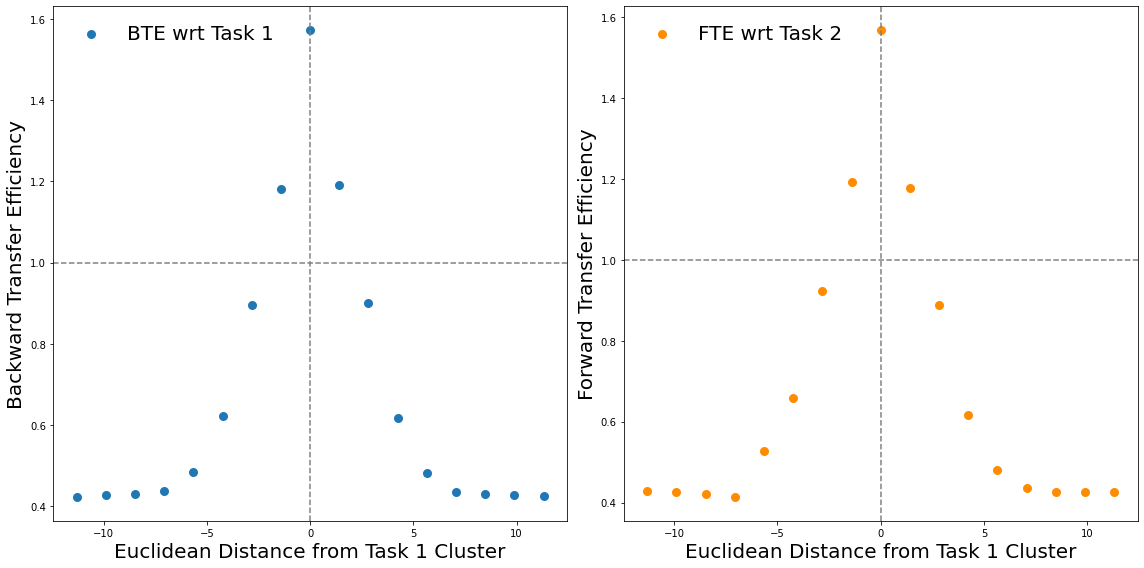

In [47]:
# Create empty Euclidean distance.
euclidean_distances = np.empty(np.shape(means_2)[0]).reshape(-1)
dist = -1

# Populate with the Euclidean distances.
for i in range(np.shape(means_2)[0]):
    temp = np.linalg.norm(np.subtract(means_1[0], means_2[i]))
    if temp == 0:
        dist = 1
    euclidean_distances[i] = temp * dist

# Plot the BTEs and 
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(euclidean_distances, mean_bte[0,1:], ls="-", lw=3, marker='o')
ax[0].set_ylabel("Backward Transfer Efficiency", fontsize=20)
ax[0].legend(['BTE wrt Task 1'], loc="upper left", fontsize=20, frameon=False)
ax[0].set_xlabel("Euclidean Distance from Task 1 Cluster", fontsize=20)
ax[0].axvline(x=0, c="gray", linewidth=1.5, linestyle="dashed")
ax[0].axhline(y=1, c="gray", linewidth=1.5, linestyle="dashed")

ax[1].scatter(euclidean_distances, mean_fte, ls="-", lw=3, c='darkorange')
ax[1].set_ylabel("Forward Transfer Efficiency", fontsize=20)
ax[1].legend(['FTE wrt Task 2'], loc="upper left", fontsize=20, frameon=False)
ax[1].set_xlabel("Euclidean Distance from Task 1 Cluster", fontsize=20)
ax[1].axvline(x=0, c="gray", linewidth=1.5, linestyle="dashed")
ax[1].axhline(y=1, c="gray", linewidth=1.5, linestyle="dashed")

right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
plt.tight_layout()